# Boxplot of top five up- and downregulated genes

In [2]:
library(ggpubr)
library(ggsignif)
library(tidyverse)

## Functions

In [3]:
add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
    as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
    dplyr::ungroup() %>%
    mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}

save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## All genes

### Differential expressed genes

In [4]:
genes = read.delim('../../_m/genes/diffExpr_EAvsAA_full.txt')
genes = genes %>% filter(adj.P.Val < 0.05) %>%  
            select(gencodeID, ensemblID, Symbol, logFC, t, adj.P.Val)
genes = add_symnum(genes)

up_genes = genes %>% filter(t > 0) %>% mutate('Direction'='Up') %>% head(5) 
down_genes = genes %>% filter(t < 0) %>% mutate('Direction'='Down') %>% head(5) 

sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(sig_genes$Symbol[xx] == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}
sig_genes

gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
ENSG00000272977.1,ENSG00000272977,,2.1971554,12.32822,1.293546e-22,< 2e-16,****,Up,ENSG00000272977
ENSG00000068654.15,ENSG00000068654,POLR1A,0.2920873,11.92291,6.364724e-22,< 2e-16,****,Up,POLR1A
ENSG00000084628.9,ENSG00000084628,NKAIN1,1.8918067,11.51866,9.739085e-21,< 2e-16,****,Up,NKAIN1
ENSG00000271361.1,ENSG00000271361,HTATSF1P2,3.4182212,10.93106,4.243489e-19,< 2e-16,****,Up,HTATSF1P2
ENSG00000140263.13,ENSG00000140263,SORD,0.6260466,10.89213,4.487638e-19,< 2e-16,****,Up,SORD
ENSG00000233913.7,ENSG00000233913,,-2.9416709,-12.21302,1.511451e-22,< 2e-16,****,Down,ENSG00000233913
ENSG00000259479.6,ENSG00000259479,SORD2P,-2.3387832,-12.08750,2.536508e-22,< 2e-16,****,Down,SORD2P
ENSG00000204894.4,ENSG00000204894,,-4.6961031,-11.30602,3.795494e-20,< 2e-16,****,Down,ENSG00000204894
ENSG00000226278.1,ENSG00000226278,PSPHP1,-5.6592558,-10.99827,2.993636e-19,< 2e-16,****,Down,PSPHP1


### Load residualized expression

In [5]:
res_file = '../../_m/genes/residualized_expression.tsv'
tmp_df = data.table::fread(res_file, data.table=F)

resdf0 = tmp_df %>% filter(V1 %in% sig_genes$gencodeID) %>% column_to_rownames("V1")
resdf0 <- data.frame(t(resdf0))
resdf0[1:2, 1:5]

Warning message in data.table::fread(res_file, data.table = F):
"Detected 239 column names but the data has 240 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,ENSG00000084628.9,ENSG00000068654.15,ENSG00000230076.1,ENSG00000233913.7,ENSG00000271361.1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R12872,-1.6202832,-2.1347384,0.8444470,0.8405757,-0.04643102
R12873,-0.8500143,0.4757107,0.8683794,1.1014922,-0.94456124


### Load pheno data

In [7]:
pheno_file = '../../../../../input/phenotypes/_m/caudate_phenotypes.csv'
pheno = read.csv(pheno_file, row.names=1) %>% mutate_if(is.character, as.factor)
levels(pheno$Race) <- c("AA", "EA")
head(pheno, 2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,mitoRate,rRNA_rate,overallMapRate
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
R12864,Br1303,R12864,Caudate,9.6,42.98,F,AA,Schizo,0.03265387,8.675159e-05,0.9093498
R12865,Br1320,R12865,Caudate,9.5,53.12,M,AA,Schizo,0.01978740,6.976684e-05,0.8734840


### Merge dataframe

In [8]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf[1:2, 1:10]

[1] 239  22

,rowname,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,mitoRate
,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>
1,R12872,Br949,R12872,Caudate,9.2,18.05,M,AA,Control,0.02136239
2,R12873,Br991,R12873,Caudate,9.4,35.24,M,AA,Control,0.02258917


### Melt data frame

In [9]:
df = resdf %>% select(c('rowname', 'Race', starts_with('ENSG'))) %>%
    pivot_longer(-c(rowname, Race), names_to = "gencodeID", values_to = "Res") %>%
    inner_join(sig_genes, by='gencodeID') %>% 
    mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)

df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
head(df, 2)

rowname,Race,gencodeID,Res,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
R12872,AA,ENSG00000084628.9,-1.620283,ENSG00000084628,NKAIN1,1.8918067,11.51866,9.739085e-21,< 2e-16,****,Up,NKAIN1
R12872,AA,ENSG00000068654.15,-2.134738,ENSG00000068654,POLR1A,0.2920873,11.92291,6.364724e-22,< 2e-16,****,Up,POLR1A


### Initial ggplot with ggpubr

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


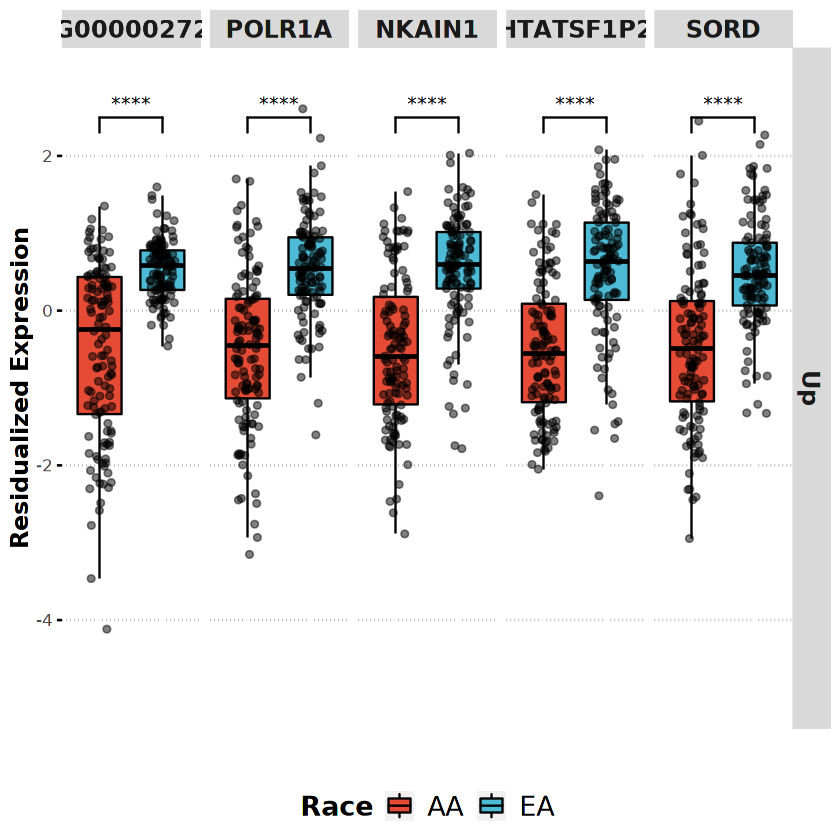

In [10]:
tmp = sig_genes %>% mutate(group1='AA', group2='EA', y_pos=2.5) %>% 
    filter(Direction == 'Up') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction=="Up") %>%
    ggboxplot(x="Race", y="Res", facet.by=c("Direction", "New_ID"), fill="Race", 
              xlab='', panel.labs.font=list(face='bold', size = 14), palette="npg", 
              outlier.shape=NA, ylab='Residualized Expression', add='jitter', 
              add.params=list(alpha=0.5), legend="bottom", ylim=c(-5, 3), 
              ggtheme=theme_pubclean()) +
        geom_signif(data=tmp, 
                    aes(xmin=group1, xmax=group2, annotations=p.signif, 
                        y_position=y_pos), 
                    manual=TRUE) + 
        font("xy.title", size=14, face="bold") + 
        font("legend.title", size=16, face="bold") + 
        font("legend.text", size=16) + rremove("x.text") + rremove("x.ticks")
         
bxp_up

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


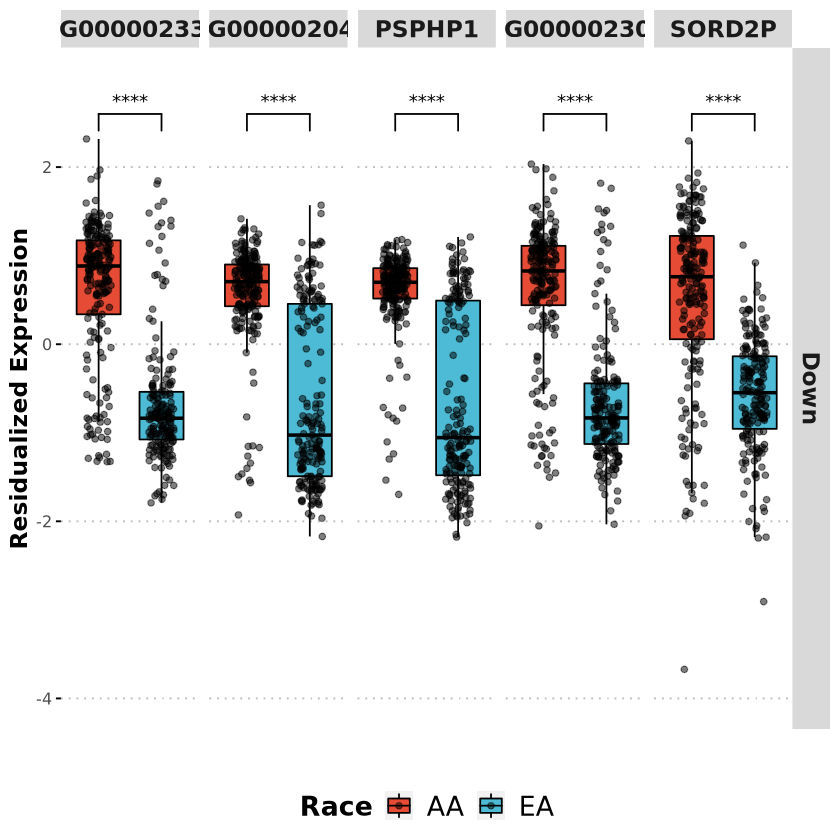

In [16]:
tmp = sig_genes %>% mutate(group1='AA', group2='EA', y_pos=2.6) %>% 
    filter(Direction == 'Down') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=='Down') %>% 
    ggboxplot(x="Race", y="Res", fill="Race", palette="npg", xlab='', add="jitter",
              outlier.shape=NA, facet.by=c("Direction", "New_ID"), ylim=c(-4, 3),
              panel.labs.font=list(face='bold', size=14), legend="bottom", 
              add.params=list(alpha=0.5), ylab='Residualized Expression', 
              ggtheme=theme_pubclean()) +
    geom_signif(data=tmp, 
                aes(xmin=group1, xmax=group2, annotations=p.signif, 
                    y_position=y_pos), 
                manual=TRUE) + 
    font("xy.title", size=14, face="bold") + 
    font("legend.title", size=16, face="bold") + 
    font("legend.text", size=16) + rremove("x.text") + rremove("x.ticks")
         
bxp_down

### Annotate figure

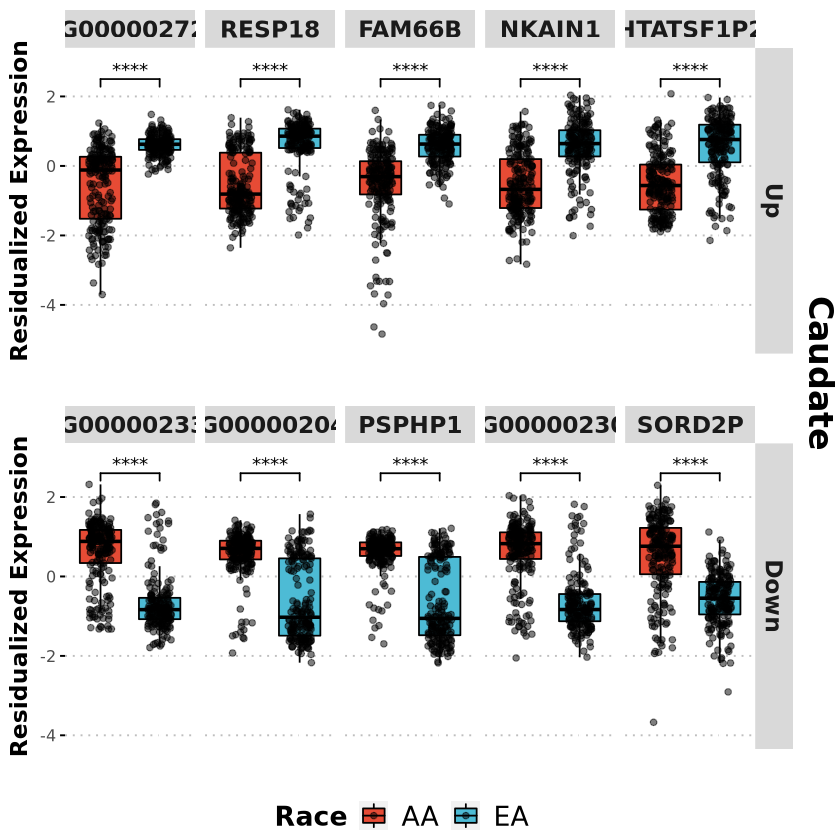

In [18]:
figure <- ggarrange(bxp_up, bxp_down, ncol=1, nrow=2, 
                    common.legend=TRUE, legend="bottom")
figure <- annotate_figure(figure, 
                          right=text_grob("Caudate", size=20, 
                                          rot=-90, face='bold', hjust=0.8))
figure

In [15]:
save_ggplots('caudate_topSig_boxplot', figure, 12, 9)

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()